You are given an excerpt of the log data from the [Swisslos](https://www.swisslos.ch) Jass servers collected between October 2017 and April 2018. In the Swiss card game [Jass](https://en.wikipedia.org/wiki/Jass), at the beginning of each round just after the cards have been dealt, the current player announces her choice of the trump mode from the options: diamonds, hearts, spades, club, obe-abe, une-ufe and push (only available when forehand). Use this information from human players to train a machine learning classifier in trump mode prediction.

In [323]:
% matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

UsageError: Line magic function `%` not found.


# Import & Prepare Data

In [324]:
path_to_data = Path('.')

In [325]:
# Import only a fraction of data for efficient development and testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None, nrows=10000)

# Import all data in the final run
# data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)

data.head()

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


In [326]:
# Display number of rows and columns
data.shape

(359825, 39)

## Rename Columns for better Interpretability

In [327]:
cards = [
    # Diamonds
    'DA', 'DK', 'DQ', 'DJ', 'D10', 'D9', 'D8', 'D7', 'D6',
    # Hearts
    'HA', 'HK', 'HQ', 'HJ', 'H10', 'H9', 'H8', 'H7', 'H6',
    # Spades
    'SA', 'SK', 'SQ', 'SJ', 'S10', 'S9', 'S8', 'S7', 'S6',
    # Clubs
    'CA', 'CK', 'CQ', 'CJ', 'C10', 'C9', 'C8', 'C7', 'C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CQ,CJ,C10,C9,C8,C7,C6,FH,user,trump
0,0,0,0,1,1,0,1,1,0,0,...,1,0,0,0,1,0,0,0,53248,6
1,0,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,1,0,0,4613,5
2,1,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,68780,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,24555,5
4,0,1,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,1,8392,4


## Remove User Information

Later on you may want to keep this information. For now, we remove it just to avoid mistakes.

In [328]:
data.drop('user', axis='columns', inplace=True)
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,0,0,0,1,1,0,1,1,0,0,...,0,1,0,0,0,1,0,0,0,6
1,0,0,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,5
2,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,6
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,0,0,0,0,5
4,0,1,0,0,0,0,0,0,1,1,...,0,0,1,0,0,0,0,0,1,4


## Adjust Datatypes

In [329]:
data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.dtypes

## Rename Target Category Values for better Interpretability

In [330]:
# Backward compatibility: Value 10 for PUSH was used in an older version by Swisslos

data.trump = data.trump.cat.rename_categories({0: 'DIAMONDS', 1: 'HEARTS', 2: 'SPADES', 3: 'CLUBS',
                                               4: 'OBE_ABE', 5: 'UNE_UFE', 6: 'PUSH', 10: 'PUSH'})
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CK,CQ,CJ,C10,C9,C8,C7,C6,FH,trump
0,False,False,False,True,True,False,True,True,False,False,...,False,True,False,False,False,True,False,False,False,PUSH
1,False,False,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,True,False,False,UNE_UFE
2,True,False,False,True,False,False,False,False,False,False,...,False,True,False,False,False,False,True,True,False,PUSH
3,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,True,False,False,False,False,UNE_UFE
4,False,True,False,False,False,False,False,False,True,True,...,False,False,True,False,False,False,False,False,True,OBE_ABE


# Data Quality Assessment

### Exercise: Sanity Check

Each row in the data now corresponds to one hand of a player plus her trump mode selection. Verify that each hand contains exactly 9 cards.

In [331]:
cardData = data.loc[:, cards]
# cardData.at[4, 'DA'] = 1
indexesWithMoreThanNineCards = []
for idx, row in cardData.iterrows():
    if (row.sum() > 9):
        indexesWithMoreThanNineCards.append(idx)
assert len(
    indexesWithMoreThanNineCards) == 0, f"There data contains illegal values \n Indexes with illegal card count: {str(indexesWithMoreThanNineCards)}"

### Exercise: Statistical Fingerprint

Swisslos claims to distribute cards randomly.
* Verify that all card features roughly have the same mean and standard deviation.
* Over a **large number of rounds**, we would expect similar percentages for diamonds, hearts, spades and clubs as selected Trump. Verify this claim.

Hint: you may want to use [np.allclose(...)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.allclose.html) in combination with an assert statement for automated checking.

#### A note on randomness - not part of exercises:

The above test is obviously a very poor guarantee of randomness. However, we perform such tests from the viewpoint of data quality rather than fairness. If you want to challenge the random number generator of Swisslos, use the NIST or Diehard test suite for randomness. Read more about random number tests <a href='https://gerhardt.ch/random.php'>here</a>. We have not done this ourselves and keep believing that the provider of Swiss lottery use a reasonable source of randomness even for online games :-)

In [332]:
np.sum(cardData, axis=0)

DA     90651
DK     89639
DQ     89238
DJ     90154
D10    88840
D9     89701
D8     88999
D7     89944
D6     90283
HA     90541
HK     89761
HQ     88653
HJ     90260
H10    88980
H9     89680
H8     89060
H7     89655
H6     90256
SA     91185
SK     90222
SQ     89997
SJ     91622
S10    89198
S9     90316
S8     89651
S7     90041
S6     90635
CA     91039
CK     89729
CQ     89402
CJ     91689
C10    89243
C9     90106
C8     89612
C7     89862
C6     90581
dtype: int64

In [333]:
np.mean(cardData, axis=0)

DA     0.251931
DK     0.249118
DQ     0.248004
DJ     0.250550
D10    0.246898
D9     0.249291
D8     0.247340
D7     0.249966
D6     0.250908
HA     0.251625
HK     0.249457
HQ     0.246378
HJ     0.250844
H10    0.247287
H9     0.249232
H8     0.247509
H7     0.249163
H6     0.250833
SA     0.253415
SK     0.250739
SQ     0.250113
SJ     0.254629
S10    0.247893
S9     0.251000
S8     0.249152
S7     0.250236
S6     0.251886
CA     0.253009
CK     0.249368
CQ     0.248460
CJ     0.254816
C10    0.248018
C9     0.250416
C8     0.249043
C7     0.249738
C6     0.251736
dtype: float64

In [334]:
np.std(cardData)

DA     0.434122
DK     0.432502
DQ     0.431854
DJ     0.433330
D10    0.431207
D9     0.432602
D8     0.431466
D7     0.432993
D6     0.433536
HA     0.433947
HK     0.432699
HQ     0.430901
HJ     0.433499
H10    0.431435
H9     0.432569
H8     0.431565
H7     0.432528
H6     0.433493
SA     0.434966
SK     0.433438
SQ     0.433078
SJ     0.435653
S10    0.431789
S9     0.433588
S8     0.432522
S7     0.433149
S6     0.434096
CA     0.434736
CK     0.432647
CQ     0.432120
CJ     0.435757
C10    0.431862
C9     0.433253
C8     0.432459
C7     0.432861
C6     0.434011
dtype: float64

In [335]:
data.trump.value_counts()

PUSH        137554
UNE_UFE      44653
SPADES       40115
CLUBS        39756
OBE_ABE      35829
HEARTS       31087
DIAMONDS     30831
Name: trump, dtype: int64

Can you explain ...
* the difference between Une-Ufe and Obe-Abe ?
* the difference between {spades, clubs} and {hearts, diamonds}

The fact that the values of the response are not distributed evenly has implications on the train-test split in the next section.

# Modelling and Prediction

### Train-Test Split

Split the available data into a training and a test set and put the test set aside for the final model evaluation. Use 20% of the data for testing, and set the random_state to 42 for reproducability. Since we found out that the classes are not distributed evenly, you need to stratify. Also, be aware that train_test_split() shuffles the data by default, which is what we want here (but not always, e.g. not in case of time series).

Your result should be the four variables *X_train, X_test, y_train, y_test*.

In [336]:
from sklearn.model_selection import train_test_split

feature_columns = cards + forehand
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

## Baseline with a Logistic Regression Classifier

We create a (linear) logistic regression classifier and evaluate it with cross validation.

In [337]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

classifier = LogisticRegression()

# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.6375


### Exercise: Stochastic Gradient Descent

Machine learning classifiers internally use an optimization algorithm. Stochastic gradient descent is a stochastic 
approximation that generally is more efficient but with a slightly lower convergence rate. Change the code in the previous cell to a logistic regression with stochastic gradient descent. Use [SGDClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier) with parameters *loss='log'* and *penalty='None'*

In [338]:
from sklearn.linear_model import SGDClassifier

classifier = SGDClassifier()
# Note that we do not use the test set here !
result = cross_val_score(classifier, X_train, y_train, cv=5, n_jobs=-1)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

Mean accuracy over 5 folds is 0.6139


## Learning Curves

Learning curves are an important diagnostic instrument in machine learning. A cross-validation generator splits the whole dataset k times into training and test data. Subsets of the training set with increasing sizes will be used to train the estimator and a score for each training subset size on the validation set will be computed. Afterwards, the scores will be averaged over all k runs for each training subset size.

As a rule of thumb, a gap between the training and validation curves indicates that using more data would improve accuracy.

In [339]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(SGDClassifier(loss='log_loss', penalty='None'),
                                                         X_train, y_train, n_jobs=-1,
                                                         train_sizes=np.linspace(0.1, 1.0, 50), cv=10,
                                                         exploit_incremental_learning=True, verbose=10)

[learning_curve] Training set sizes: [ 25907  30665  35424  40182  44941  49699  54458  59216  63975  68733
  73492  78250  83009  87767  92526  97284 102043 106801 111560 116318
 121077 125835 130594 135352 140111 144869 149628 154386 159145 163903
 168662 173420 178179 182937 187696 192454 197213 201971 206730 211488
 216247 221005 225764 230522 235281 240039 244798 249556 254315 259074]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of  10 | elapsed:   12.4s remaining:  1.9min
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:   12.7s remaining:   29.9s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:   12.8s remaining:   12.8s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   12.9s remaining:    5.5s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   13.0s finished


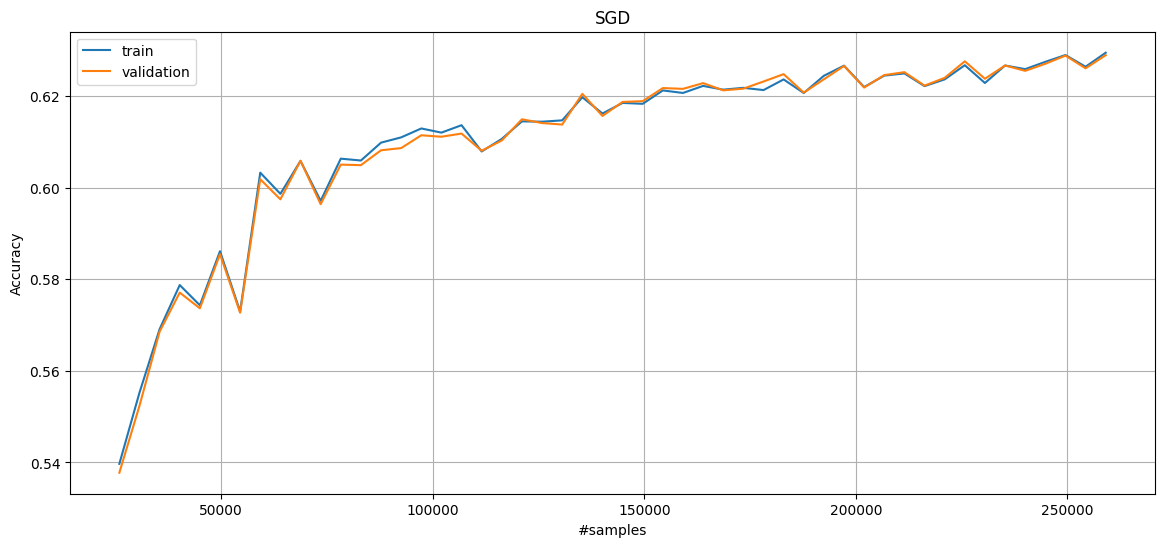

In [340]:
plot_data = pd.DataFrame({'train': train_scores.mean(axis=1), 'validation': valid_scores.mean(axis=1)},
                         index=train_sizes)
f, ax = plt.subplots(figsize=(14, 6))
ax.set_xlabel('#samples')
ax.set_ylabel('Accuracy')
ax.set_title('SGD')
plot_data.plot(ax=ax)
plt.grid()

### Exercise: Create a Random Forest Classifier

Now create a random forest classifier and evaluate it with cross validation.

In [341]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

classifier = RandomForestClassifier()
result = cross_validate(classifier, X_train, y_train, cv=5, n_jobs=-1, return_estimator=True)

print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result['test_score'])))

OSError: [WinError 1450] Insufficient system resources exist to complete the requested service

### Exercise: List and Plot Feature Importances

Tree classifiers (such as decision trees and random forests) can conveniently list feature importances. They use feature values to split the training set, whereas more important features are used higher in the tree(s). Use the *feature_importances_* attribute of a trained RandomForestClassifier to obtain a sorted list of the most important features. Plot feature importances in a bar chart.

In [ ]:
feature_importances = []
for idx, estimator in enumerate(result['estimator']):
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index=X_train.columns,
                                       columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

In [ ]:
print(np.std(feature_importances))
print(np.mean(feature_importances, axis=0))
# plt.figure(figsize=(10,4))
plt.boxplot(feature_importances)
plt.show()

## Grid Search over multiple Classifiers and Hyperparameters

In [ ]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

# Classifier names
names = [
    "Logistic Regression",
    "Random Forest",
    "SVC",
    "KNeighborsClassifier",
    "GradientBoostingClassifier",
    "GaussianProcessClassifier"
]

# Classifiers
classifiers = [
    LogisticRegression(solver='lbfgs', multi_class='multinomial'),
    # set these to avoid a FutureWarning with scikit-lean < 0.22
    RandomForestClassifier(n_estimators=200),
    SVC(),
    KNeighborsClassifier(),
    GradientBoostingClassifier(),
    GaussianProcessClassifier()
]

# Hyperparameter grid to search per classifier
parameters = [
    {'C': [0.5, 1.0, 2.0]},
    {'max_depth': [5, 10]},
    {},
    {'n_neighbors': [1, 3, 5, 6, 10]},
    {},
    {}
]

list(zip(names, parameters))

In [ ]:
from sklearn.model_selection import GridSearchCV

results = []

for name, classifier, params in zip(names, classifiers, parameters):
    print("Grid search for {}".format(name))
    gs = GridSearchCV(classifier, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best accuracy score found: {:.3f} with best estimator: {}\n".format(gs.best_score_, gs.best_estimator_))
    results.append([name, gs.best_score_, gs.best_estimator_])

results

Comment: If *refit=True* (the default), the best estimator is made available at the *best_estimator_* attribute of gs and permits using *.predict()* directly on this GridSearchCV instance. Note, however, that the above code runs grid search separately for each classifier, and so gs now only contains the last estimator of the list, which may or may not be the best one. So don't use gs to predict blindly.

### Exercise: Extend Grid Search by adding other Classifiers and Hyperparameters

You may want to experiment with a [nearest neighbors classifier](http://scikit-learn.org/stable/modules/neighbors.html) or a [support vector machine](http://scikit-learn.org/stable/modules/svm.html) or a [neural network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) or ...

### Exercise: Add interactions to Logistic Regression

A linear classifier such as logistic regression cannot model dependencies between features (things like "if your hand has both heart jack and heart nine, then choose heart as trump mode"). But features like these called *interactions* can be added manually.

In [ ]:
# First, get the score without interactions
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

For each of the four colors, add one interaction term for the combination jack and nine.

In [ ]:
for color in 'DHSC':
    # Jack and nine combination
    new_col = '{}_J9'.format(color)
    data[new_col] = data['{}J'.format(color)] & data['{}9'.format(color)]
    feature_columns.append(new_col)

    # new_col = '{}_AKQ'.format(color)
    # data[new_col] = data['{}A'.format(color)] & data['{}K'.format(color)] & data['{}Q'.format(color)]
    # feature_columns.append(new_col)
data.head()

We must recreate training and test sets with the new features

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[feature_columns], data.trump, test_size=0.2,
                                                    stratify=data.trump, random_state=42)

And check  if the additional columns improve the score

In [ ]:
clf = LogisticRegression(C=0.8, solver='lbfgs', multi_class='multinomial')
result = cross_val_score(clf, X_train, y_train, cv=5, n_jobs=-1)
print("Mean accuracy over 5 folds is {:.4}".format(np.mean(result)))

### Exercise: Better Accuracy with less Data ?

At the beginning we removed the user ID from our data set. Use this information to develop a heuristic that seggregates between *good* and *bad* players. Can you improve accuracy by using only the data from *good* players?

In [ ]:
# todo

### Exercise: The final Score

Use the best setting you could find, train the classifier on all training data and evaluate on the yet unseen test data.

In [ ]:
# Probably not the best :-)
clf = LogisticRegression(C=0.5, solver='lbfgs', multi_class='multinomial')

clf.fit(X_train, y_train)
clf.score(X_test, y_test)